In [1]:
import os
import numpy as np
import pandas as pd
import array
import mmap
import matplotlib.pyplot as plt
import seaborn as sns
sep = '/'

In [2]:
path = "/Users/sharplab/tran/cat/Tran/2018-05-03_02 (done)/2018-05-03_02.dat"
kilosort_folder = '/Users/sharplab/tran/cat/Tran'
recording = '2018-05-03_02 (done)'
fig_path = "/Users/sharplab/tran/cat/Tran/2018-05-03_02 (done)/figures"
data = np.memmap(path, shape =(327354368,32), dtype = np.int16)


def load_kilosort_arrays(recording):
    spike_clusters = np.load('spike_clusters.npy')
    spike_times = np.load('spike_times.npy')
    cluster_groups = pd.read_csv('cluster_groups.csv', sep='\t')
    try:  # check data quality
        assert np.shape(spike_times.flatten()) == np.shape(spike_clusters)
    except AssertionError:
        AssertionError('Array lengths do not match in recording {}'.format(
            recording))
    return spike_clusters, spike_times, cluster_groups

def load_data(recording, kilosort_folder, verbose, sep):
    if verbose:
        print('\nLoading Data:\t{}\n'.format(recording))
        os.chdir(sep.join([kilosort_folder, recording]))
        spike_clusters, spike_times, cluster_groups = load_kilosort_arrays(
            recording)
    return spike_clusters, spike_times, cluster_groups

def get_good_cluster_numbers(cluster_groups_df):
    good_clusters_df = cluster_groups_df.loc[cluster_groups_df['group'] == 'good', :]
    return good_clusters_df['cluster_id'].values

spike_clusters, spike_times, cluster_groups = load_data(recording=recording,
                                                        kilosort_folder=kilosort_folder,
                                                        verbose=True,
                                                        sep=sep)

good_cluster_numbers = get_good_cluster_numbers(cluster_groups)


Loading Data:	2018-05-03_02 (done)



In [3]:
def find_baseline(max_peak_time, counter, correct_chan): #Method to find baseline is standardised for all types of waveforms 
    baseline = []
    counter = np.arange(0, max_peak_time, 1)
    for time_point in counter:
        if correct_chan.loc[time_point][0] > (correct_chan.loc[max_peak_time][0]/50):
            baseline.append(time_point)
        else:
            pass
    return baseline

def find_return_point(min_peak_time, from_min_to_end, correct_chan):
    return_point = []
    from_min_to_end = np.arange(min_peak_time, 60, 1)
    for return_time_point in from_min_to_end:
        if np.absolute(np.absolute(correct_chan.loc[return_time_point][0]) - correct_chan.loc[find_baseline(max_peak_time, counter, correct_chan)[0]][0])<(correct_chan.loc[find_baseline(max_peak_time, counter, correct_chan)[0]][0]/2):
            return_point.append(return_time_point)
        else:
            pass
    return return_point

def plot_waveform(fig_to_save, correct_chan, baseline, min_peak_time, return_point):
    plt.plot(correct_chan, linestyle=None, marker='.')
    plt.plot(np.ones(5)*baseline[0], np.linspace(-400, 650, 5), 'k')
    plt.plot(np.ones(5)*min_peak_time, np.linspace(-400, 650, 5), 'k')
    plt.plot(np.ones(5)*return_point[0], np.linspace(-400, 650, 5), 'k')
    
    a = (correct_chan.loc[return_point[0]][0]-correct_chan.loc[return_point[0]+1][0])/(return_point[0]-(return_point[0]+1))
    b = correct_chan.loc[return_point[0]][0]-a*(return_point[0])

    estimated_return_time = (correct_chan.loc[baseline[0]][0]-b)/a
    plt.plot(np.ones(5)*estimated_return_time, np.linspace(-400, 650, 5), 'r')

    plt.savefig(sep.join(fig_to_save))

def find_return_point_when_no_min(max_peak_time, counter_when_no_min, correct_chan):
    counter_when_no_min = np.arange(max_peak_time, 60, 1)
    return_point_when_no_min = []
    for no_min_return_point in counter_when_no_min:
        if np.absolute(correct_chan.loc[no_min_return_point][0] - correct_chan.loc[find_baseline(max_peak_time, counter, correct_chan)[0]][0])<(correct_chan.loc[find_baseline(max_peak_time, counter, correct_chan)[0]][0]/2):
            return_point_when_no_min.append(no_min_return_point)
        else:
            pass
    return return_point_when_no_min


def plot_waveform_when_no_min(fig_to_save, baseline, correct_chan, no_min_return_point):
    plt.plot(correct_chan, linestyle=None, marker='.')
    plt.plot(np.ones(5)*baseline[0], np.linspace(-400, 650, 5), 'k')
    plt.plot(np.ones(5)*no_min_return_point[0], np.linspace(-400, 650, 5), 'k')
    
    a = (correct_chan.loc[no_min_return_point[0]][0]-correct_chan.loc[no_min_return_point[0]+1][0])/(no_min_return_point[0]-(no_min_return_point[0]+1))
    b = correct_chan.loc[no_min_return_point[0]][0]-a*(no_min_return_point[0])

    estimated_return_time = (correct_chan.loc[baseline[0]][0]-b)/a
    plt.plot(np.ones(5)*estimated_return_time, np.linspace(-400, 650, 5), 'r')
    plt.savefig(sep.join(fig_to_save))



In [6]:
num_spikes_for_averaging = 1000
num_channels = 32
num_samples_per_waveform = 60
waveform_window = np.arange(int(-num_samples_per_waveform/2),int(num_samples_per_waveform/2))


IndexError: list index out of range

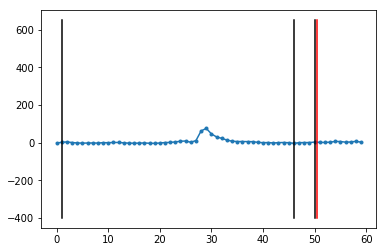

In [9]:
for cluster_no in np.arange(0,41,1):
    cluster_to_plot = good_cluster_numbers[cluster_no]
    fig_to_save = [fig_path,"cluster"+ str(cluster_to_plot)+'png']
                                                                   
    df = pd.DataFrame({'cluster':spike_clusters.flatten(), 'spike_times':spike_times.flatten()})
    df = df.loc[df['cluster'].isin(good_cluster_numbers)]
    extracted_spikes = df[df['cluster']==cluster_to_plot]['spike_times'][0:num_spikes_for_averaging]
    threeD_matrix = np.zeros((num_spikes_for_averaging, num_samples_per_waveform, num_channels)) 

    for spike in np.arange(0,num_spikes_for_averaging):
        start_index = int(extracted_spikes.iloc[spike]+waveform_window[0])  #  start of waveform in raw data
        end_index = int((extracted_spikes.iloc[spike]+waveform_window[-1])+1)  #  end of waveform in raw data

        waveform = data[start_index:end_index, 0:num_channels] #  extract waveform from raw data
        threeD_matrix[spike, :, :] = waveform[:,:]  #  add extracted waveform to 3d matrix

    mean_waveform = np.mean(threeD_matrix, axis=0)
                                           
                                           
    waveform_per_channel_df = pd.DataFrame(mean_waveform)
    maxes = waveform_per_channel_df.apply(np.max, axis=0)
    lab = maxes.idxmax()
    
    correct_chan = waveform_per_channel_df.loc[:, lab]
    correct_chan = correct_chan.reset_index()
    correct_chan.columns = ['figure', 'y_values']
    correct_chan.set_index('figure', inplace=True)
    
    max_peak_time = correct_chan.idxmax()[0]
    min_peak_time = correct_chan.idxmin()[0]

    counter = np.arange(0, max_peak_time, 1)
    from_min_to_end = np.arange(min_peak_time, 60, 1)
    counter_when_no_min = np.arange(max_peak_time, 60, 1)

    baseline = find_baseline(max_peak_time, counter, correct_chan)

    
    if (correct_chan.max()[0]-correct_chan.loc[baseline[0]][0])<50 or (correct_chan.max()[0]-correct_chan.loc[baseline[0]][0]>50 and correct_chan.idxmax()[0]>correct_chan.idxmin()[0] and correct_chan.min()[0]<-50):
        return_point = find_return_point(min_peak_time, from_min_to_end, correct_chan)
        Base_to_min = (correct_chan.idxmin()[0]-baseline[-1])/30
        Base_to_return_to_base = (return_point[0]-baseline[0])/30
        amplitude_base_to_min = correct_chan.min()[0] - correct_chan.loc[baseline[0]][0]
        data_table = pd.DataFrame({'Base to min (ms)':Base_to_min, 
                                   'Return to base (ms)': Base_to_return_to_base, 
                                   'Amplitude base-min (V)':amplitude_base_to_min,
                                  'spike_category': 'down_up'},
                                  index=[0])
        plot_waveform(fig_to_save, correct_chan, baseline, min_peak_time, return_point)

    elif (correct_chan.max()[0]-correct_chan.loc[baseline[0]][0])>50 and correct_chan.idxmax()[0]>correct_chan.idxmin()[0] and correct_chan.min()[0]>-50:
        no_min_return_point = find_return_point_when_no_min(max_peak_time, counter_when_no_min, correct_chan)
        Base_to_max = (correct_chan.idxmax()[0]-baseline[0])/30
        Base_to_return_to_base = (no_min_return_point[0]-baseline[0])/30
        amplitude_base_to_peak = correct_chan.max()[0] - correct_chan.loc[baseline[0]][0]
        data_table = pd.DataFrame({'Base to max (ms)':Base_to_max, 
                                   'Return to base (ms)': Base_to_return_to_base, 
                                   'Amplitude base-max (V)':amplitude_base_to_peak, 
                                  'spike_category': 'just_up'}, index=[0])
        plot_waveform_when_no_min(fig_to_save, baseline, correct_chan, no_min_return_point)

    else:
        return_point = find_return_point(min_peak_time, from_min_to_end, correct_chan)
        Base_to_max = (correct_chan.idxmax()[0]-baseline[0])/30
        Base_to_min = (correct_chan.idxmin()[0]-baseline[0])/30
        Base_to_return_to_base = (return_point[0]-baseline[0])/30
        amplitude_base_to_peak = correct_chan.max()[0] - correct_chan.loc[baseline[0]][0]
        amplitude_min_to_max = correct_chan.max()[0] - correct_chan.min()[0]
        data_table = pd.DataFrame({'Base to max (ms)':Base_to_max, 
                                   'Base to min (ms)':Base_to_min, 
                                   'Return to base (ms)': Base_to_return_to_base, 
                                   'Amplitude base-max (V)':amplitude_base_to_peak, 
                                   'Amplitude min-max (V)':amplitude_min_to_max,
                                  'spike_category': 'up_down_up'}, index=[0])
        plot_waveform(fig_to_save, correct_chan, baseline, min_peak_time, return_point)
